<a href="https://colab.research.google.com/github/dewi31/dewi31.github.io/blob/master/Klasifikasi_X_ray_Tuberkulosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset          Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           1921         83  1.0              
nelgiriyewithana/countries-of-the-world-2023                      Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33            855         39  1.0              
shuvammandal121/9000-companies-and-its-ratings-dataset            9000 companies and its ratings dataset              202KB  2023-07-12 04:52:05            508         27  1.0              
arnavsmayan/netflix-userbase-dataset              

In [2]:
# Mendownload dataset dari kaggle
!kaggle datasets download -d 'tawsifurrahman/tuberculosis-tb-chest-xray-dataset'

 99% 658M/663M [00:06<00:00, 137MB/s]
100% 663M/663M [00:06<00:00, 111MB/s]


In [3]:
# Mengekstrak file zip
!pip install patool
import patoolib
patoolib.extract_archive('/content/tuberculosis-tb-chest-xray-dataset.zip')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.5 MB/s eta 0:00:00
patool: Extracting /content/tuberculosis-tb-chest-xray-dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_xmjjfj9i -- /content/tuberculosis-tb-chest-xray-dataset.zip
patool: ... /content/tuberculosis-tb-chest-xray-dataset.zip extracted to `TB_Chest_Radiography_Database'.


'TB_Chest_Radiography_Database'

In [4]:
# Split folder menggunakan library split folder
!pip install split-folders
import splitfolders

folder = '/content/TB_Chest_Radiography_Database'
splitfolders.ratio(folder, output = '/content/Dataset split', seed = 42, ratio = (.8,.2))

Copying files: 4200 files [00:02, 1780.74 files/s]


In [5]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop,Adam
from keras import layers
from keras import Model
from keras.applications.vgg19 import VGG19

In [6]:
import os
dir = os.listdir('/content/Dataset split/val')
print(dir)

['Tuberculosis', 'Normal']


In [7]:
train_dir = '/content/Dataset split/train'
validation_dir = '/content/Dataset split/val'

train_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # YOUR IMAGE SIZE SHOULD BE 150x150
train_generator= train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=25,
                                                      class_mode='binary',
                                                      target_size=(256, 256))
validation_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                  batch_size=20,
                                                                  class_mode='binary',
                                                                  target_size=(256, 256))

Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [8]:
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in VGG_model.layers:
	layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [9]:
from keras.layers import Flatten,Dense
from keras.models import Model, Sequential
model = Sequential()
model.add(VGG_model)
model.add(Flatten())
model.add(Dense(218, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 218)               7143642   
                                                                 
 dense_1 (Dense)             (None, 1)                 219       
                                                                 
Total params: 27,168,245
Trainable params: 7,143,861
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
#set custom callback
class Callback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('val_accuracy') > 0.95):
                print('Stop training model...')
                self.model.stop_training = True

callback = Callback()

In [12]:
model.compile(loss = 'binary_crossentropy', optimizer= Adam(learning_rate=0.001), metrics = ['accuracy'])
model.fit(train_generator, epochs = 20,
          validation_data = validation_generator,
          steps_per_epoch=10,
          validation_steps=5,
          callbacks=[callback])

Epoch 1/20
10/10 [==============================] - 225s 23s/step - loss: 0.3749 - accuracy: 0.9000 - val_loss: 0.1842 - val_accuracy: 0.9300
Epoch 2/20
10/10 [==============================] - 243s 25s/step - loss: 0.0411 - accuracy: 0.9800 - val_loss: 0.0461 - val_accuracy: 0.9700


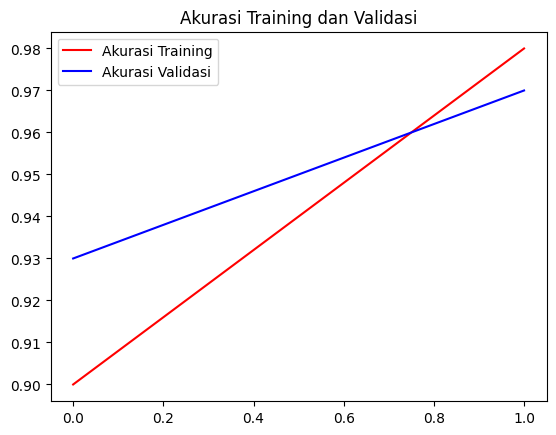

<Figure size 640x480 with 0 Axes>

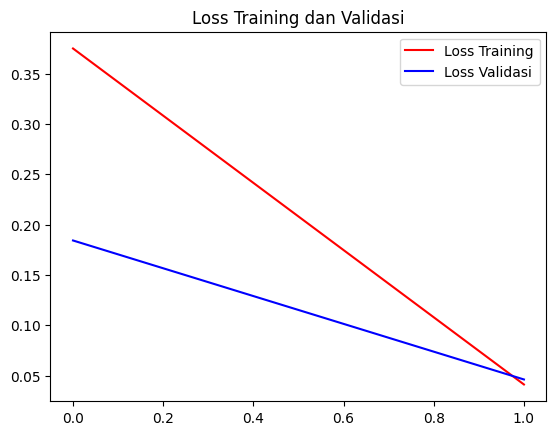

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [13]:
# Save model
model.save("model_klasifikasi.h5")

In [21]:
# Load model dengan akurasi terbaik
new_model = tf.keras.models.load_model('/content/model_klasifikasi.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 218)               7143642   
                                                                 
 dense_1 (Dense)             (None, 1)                 219       
                                                                 
Total params: 27,168,245
Trainable params: 7,143,861
Non-trainable params: 20,024,384
_________________________________________________________________


Saving Tuberculosis-101.png to Tuberculosis-101 (1).png
1/1 [==============================] - 1s 710ms/step
Citra X-ray Tuberculosis


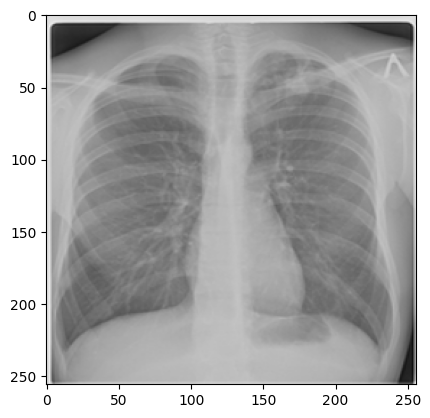

In [22]:
# Melakukan pengujian dengan model terbaik
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = load_img(path, target_size=(256, 256))
  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = new_model.predict(images, batch_size=10)
  # print(classes)

  if classes[0]==1:
    print('Citra X-ray Tuberculosis')
  else:
    print('Citra X-ray Normal')